# Bayes Naive Classifier
This machine learning technique that is great at detecting patterns.

It's a family of classifiers based on Bayes' Theorem.
$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$
What this says is that it can calculate the probability of event $A$ given that $B$ happened, i.e. $P(A|B)$. In the context of machne learning this means that it can find the probability for a certain label given the input data of the data point we are trying to predict.

The right side of this equation is what we can find through training the model. The numerator is effectively the probability of $A$ and $B$ both happening. You can extend this to have many more events, so you get the probability of $A$ happening given $B$, $C$, $D$, etc., i.e. $P(A|B,C,D,...)$.

Bringing this back to machine learning, it means that you can get the probability of something you want to predict based on the probabilities of features $x_1, x_2, x_3, ...$ in the dataset which you can calculate! However, this technically only holds if the features are all independent though.

This almost never true, for example when your data is weather data like with the Ottawa biking, then temperature and rain and snow will surely be related. However, it works remarkably well even if there is a bit of dependence between the features.  That's why it's call **Naive** Bayes.

In [61]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import scipy.optimize

## Iris data set

The classic Iris data set works very well with Bayes. This it the data set that has petal length and other physical properties linked to the type of iris.

I'm using this dataset here just to show you the minimum amount of steps to use Naive Bayes.

In [2]:
# Load the iris dataset
iris = datasets.load_iris()
X = iris['data']  # features
y = iris['target']  # labels
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Train a Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [5]:
# Make predictions on the test set
y_pred = gnb.predict(X_test)

In [6]:
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


So, 100% accuracy. Boring!

## SMS Spam

One of the common applications of Naive Bayes is in detecting spam. It's a very fast method which is good since roughly 50% of all emails sent globally are spam! It's better for text messages since those cost a tiny bit of money to send. Either way, it's really annoying!

One way of filtering spam is letting the filter look at words commonly used by spammers and words commonly used in real messages. Here is a dataset of text messages sent to phones.

Almeida,Tiago and Hidalgo,Jos. (2012). SMS Spam Collection. UCI Machine Learning Repository. https://doi.org/10.24432/C5CC84.

In [7]:
textmessages = pd.read_csv('data/SMSSpamCollection', sep='\t', header=None, names=['spam_or_ham','text'])
textmessages.head(10)

,spam_or_ham,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


We would like to look at word frequencies. Messages that have a lot of "bad" words will be more likely to be spam, messages with a lot of "good" words are probably real. So we need to count words. Fortunately, Scikit-learn comes with a feature extractor exactly for that.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
count_vect = CountVectorizer()
X = count_vect.fit_transform(textmessages.text)

In [10]:
X

<5572x8713 sparse matrix of type '<class 'numpy.int64'>'
	with 74169 stored elements in Compressed Sparse Row format>

So there are 74,169 unique words in the complete dataset. Each word has a frequency which is the input for our model. That's a lot of features! Fortunately, that is one of the strong point of Naive Bayes.

Then we just need the labels which is 'spam' or 'ham'. Then split the training set and feed the train data to the model to train on.

In [11]:
y = textmessages['spam_or_ham']

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2, random_state=42)

In [13]:
# Train a Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

We now have a trained model. Let's see what the accuracy is.

In [14]:
# Make predictions on the test set
y_pred = gnb.predict(X_test)

In [15]:
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9067264573991032


Roughtl 90% so that's pretty decent.

In [16]:
confusion_matrix(y_test, y_pred)

array([[873,  93],
       [ 11, 138]])

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

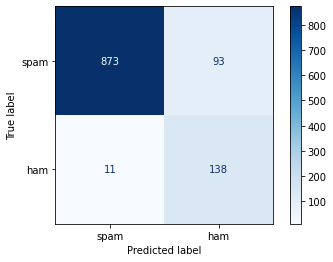

In [18]:
ConfusionMatrixDisplay.from_estimator(
        gnb,
        X_test,
        y_test,
        display_labels=["spam","ham"],
        cmap=plt.cm.Blues,
#        normalize=normalize,
    )

## Book genres

### Data
Use the CMU Book Summary Dataset at https://www.cs.cmu.edu/~dbamman/booksummaries.html

This dataset is tab separated without a header row. Column names comes from the accompying README.

In [19]:
books = pd.read_csv('data/booksummaries.txt', sep="\t", header=0, names=['wikipedia', 'freebase', 'title', 'author', 'publicationdate', 'genres', 'summary'])

In [20]:
# I don't feel like dealing with NaN
books = books.dropna()
books.head()

,wikipedia,freebase,title,author,publicationdate,genres,summary
0,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
1,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."
5,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger..."
7,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul..."


Genres are in a JSON format, so we will need the JSON package to extract those.

In [21]:
import json

Convert that JSON into a simple list. We don't care about the weird identifiers.

In [22]:
def genre(row):
    g = json.loads(row.genres)
    return list(g.values())

genresperbook = books.apply(genre, axis=1)
books = books.assign(genres=genresperbook)

In [23]:
books.head()

,wikipedia,freebase,title,author,publicationdate,genres,summary
0,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
1,986,/m/0ldx,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge..."
5,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"[Children's literature, Fantasy, Speculative f...","Ged is a young boy on Gont, one of the larger..."
7,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul..."


### Feature extraction
Unlike the penguins, we now want to predict multiple labels. One way we can do this is by creating a dummy column like we did for the islands before. Now we need a dummy column for each genre.

The following code does that. It's fairly dark magic and full transparency, I just copied it mostly from StackOverflow, but what it does is that it takes the lists in the genres column and converts them to a Pandas Series. Then it stacks them one on the other while keeping the main index but with a sub index for each genre per book. Then we get the dummies for that. The result of that is still a multi-index DataFrame but now with a column for every genre per book per listed genre for that book.

We need to collapse that back into a single-index DataFrame again, so we group all that by the first index of our multi-index DataFrame which is the index for the books. We sum on that which means that per book we now have a single row that has a 1 if that book is part of a certain genre and 0 if not. Then we add a prefix to the column name.

In [24]:
dummies = books.genres.apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('genre_')
books = books.join(dummies)

In [25]:
books

,wikipedia,freebase,title,author,publicationdate,genres,summary,genre_Absurdist fiction,genre_Adventure,genre_Adventure novel,...,genre_Utopian fiction,genre_Vampire fiction,genre_War novel,genre_Western,genre_Western fiction,genre_Whodunit,genre_Wuxia,genre_Young adult literature,genre_Zombie,genre_Zombies in popular culture
0,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,986,/m/0ldx,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge...",0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"[Children's literature, Fantasy, Speculative f...","Ged is a young boy on Gont, one of the larger...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16548,36372465,/m/02vqwsp,The Third Lynx,Timothy Zahn,2007,[Science Fiction],The story starts with former government agent...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16550,36534061,/m/072y44,Remote Control,Andy McNab,1997,"[Thriller, Fiction, Suspense]",The series follows the character of Nick Ston...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16554,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16555,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,[Autobiography],The book follows very rough chronological ord...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Phew!! Now the data is in a form we can use for the labels.

Let's look a bit closer at the genres and in particular how many books we have in each category. We'll just sum the dummy columns for genres.

In [26]:
genreusage = books.drop(['wikipedia', 'freebase', 'author', 'publicationdate', 'genres', 'title', 'summary'], axis=1).sum().sort_values(ascending=False)
genreusage

genre_Fiction                3674
genre_Speculative fiction    3270
genre_Novel                  2088
genre_Science Fiction        2001
genre_Fantasy                1863
                             ... 
genre_Prose                     1
genre_Photography               1
genre_Indian chick lit          1
genre_Superhero fiction         1
genre_Neuroscience              1
Length: 215, dtype: int64

So there are a whole bunch of genres that only have one book in the dataset. As you can imagine, this is not going to work well when training the model. So let's put in a lower limit of say 200. How many genres do we have still?

In [27]:
genreusage = genreusage.reset_index().rename(columns={0: "count"})
genreusage = genreusage[genreusage["count"] > 200]
genreusage

,index,count
0,genre_Fiction,3674
1,genre_Speculative fiction,3270
2,genre_Novel,2088
3,genre_Science Fiction,2001
4,genre_Fantasy,1863
5,genre_Children's literature,1627
6,genre_Mystery,973
7,genre_Young adult literature,625
8,genre_Crime Fiction,557
9,genre_Historical novel,551


In [28]:
genretrainlist = list(genreusage["index"])
genretrainlist

['genre_Fiction',
 'genre_Speculative fiction',
 'genre_Novel',
 'genre_Science Fiction',
 'genre_Fantasy',
 "genre_Children's literature",
 'genre_Mystery',
 'genre_Young adult literature',
 'genre_Crime Fiction',
 'genre_Historical novel',
 'genre_Suspense',
 'genre_Thriller',
 'genre_Horror',
 'genre_Romance novel',
 'genre_Historical fiction',
 'genre_Adventure novel']

In [29]:
dummies = dummies[genretrainlist]

### Input
Next is the input. These are the summaries for a book which is essentially a collection of words. We can vectorize that by making a vector that has a length ot however many unique words there are in all the summaries combined. Then each book summary can be represented as a vector that counts the number of words.

That sounds complicated to do, but fortunately, Scikit can do it for us.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [31]:
count_vect = CountVectorizer()

In [32]:
X = count_vect.fit_transform(books.summary)

In [33]:
X[0]

<1x90759 sparse matrix of type '<class 'numpy.int64'>'
	with 486 stored elements in Compressed Sparse Row format>

In [34]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

### Train

In [35]:
dummies.columns

Index(['genre_Fiction', 'genre_Speculative fiction', 'genre_Novel',
       'genre_Science Fiction', 'genre_Fantasy', 'genre_Children's literature',
       'genre_Mystery', 'genre_Young adult literature', 'genre_Crime Fiction',
       'genre_Historical novel', 'genre_Suspense', 'genre_Thriller',
       'genre_Horror', 'genre_Romance novel', 'genre_Historical fiction',
       'genre_Adventure novel'],
      dtype='object')

In [36]:
for col in dummies.columns:
    # Split the data into training and testing sets
    #y = dummies[col]
    #X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2, random_state=42)
    
    # X.toarray() is very memory intensive. Limit the amount of data used of you don't have loads of memory
    # by using [:4000] for the input data. This will work for 16GB. If you have less, use a lower number
    y = dummies[col][:4000]
    X_train, X_test, y_train, y_test = train_test_split(X.toarray()[:4000], y, test_size=0.2, random_state=42)
    
    # Train a Gaussian Naive Bayes classifier
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = gnb.predict(X_test)
    
    # Evaluate the performance of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {col}: {accuracy}")

Accuracy for genre_Fiction: 0.56125
Accuracy for genre_Speculative fiction: 0.69
Accuracy for genre_Novel: 0.71125
Accuracy for genre_Science Fiction: 0.7875
Accuracy for genre_Fantasy: 0.87
Accuracy for genre_Children's literature: 0.83125
Accuracy for genre_Mystery: 0.91875
Accuracy for genre_Young adult literature: 0.96625
Accuracy for genre_Crime Fiction: 0.96
Accuracy for genre_Historical novel: 0.95125
Accuracy for genre_Suspense: 0.93375
Accuracy for genre_Thriller: 0.96125
Accuracy for genre_Horror: 0.94875
Accuracy for genre_Romance novel: 0.96875
Accuracy for genre_Historical fiction: 0.95625
Accuracy for genre_Adventure novel: 0.9775


Looks like we can predict most genres pretty well! Especially when compared to the KNN we tried using before. It does have a lot of trouble prediction "Fiction". This might be because that label is probably too generic. As in lots of different genres can be classified as fiction.

The difference between Naive Bayes and KNN is that Naive Bayes works particularly well with loads and loads of input columns whereas that is exactly where KNN breaks down. This is a good example of the consequences of model choice.

## School grades

Ontario produces open data sets with statistics for schools. We can download it from their catalogue. **FAILURE**

### Why it probably failed
Even though Naive Bayes works remarkably well when features are not actually independent, there is a limit in how far you can take this. The data below has grade results over a range of grades and subjects. It is likely that they are all heavily correlated with each other. That is, a school that has grade 6 students doing really well in reading likely also has grades do well in writing and math and for the grade 9 students as well.

### Data cleaning

They indicate missing data with "NA" but there is also "SP" which means the enrollment was too low to report data on student performance without privacy concerns. We'll tell pandas to treat both "SP" and "NA" as missing values. They also have "N/D" and "N/R" which are just special cases of "NA" so we can treat those as missing data as well.

In [37]:
schools = pd.read_excel('data/new_sif_data_table_2021_22prelim_en_november2023.xlsx', na_values=["NA","SP", "N/D", "N/R"])

Let's see what we have in terms of data quality.

In [38]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 49 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Board Number                                                                      4904 non-null   object 
 1   Board Name                                                                        4904 non-null   object 
 2   Board Type                                                                        4904 non-null   object 
 3   School Number                                                                     4904 non-null   object 
 4   School Name                                                                       4904 non-null   object 
 5   School Type                                                                       4904 non-null   object 
 6   

Many columns seem to have no data at all. Some are just a bit poor. Some contain address information and websites. We can drop many of those. Let's start with dropping names, addresses and ID numbers.

In [39]:
schools = schools.drop([
    'Board Number',
    'Board Name',
    'Board Type',
    'School Number',
    'School Name',
    'School Special Condition Code',
    'Building Suite',
    'P.O. Box',
    'Street',
    'Municipality',
    'City',
    'Province',
    'Postal Code',
    'Phone Number',
    'Fax Number',
    'School Website',
    'Board Website',
    'Longitude',
    'Latitude',
    'Extract Date'
], axis=1)

In [40]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 29 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   School Type                                                                       4904 non-null   object 
 1   School Level                                                                      4904 non-null   object 
 2   School Language                                                                   4904 non-null   object 
 3   Grade Range                                                                       4904 non-null   object 
 4   Enrolment                                                                         4677 non-null   float64
 5   Percentage of Students Whose First Language Is Not English                        4677 non-null   float64
 6   

We still have rather a lot of columns with no data at all. Let's drop those as well.

Actually, let's also get rid of the columns that have fewer than 1000 valid values.

In [41]:
schools = schools.dropna(thresh=1000, axis=1)

In [42]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 19 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   School Type                                                                       4904 non-null   object 
 1   School Level                                                                      4904 non-null   object 
 2   School Language                                                                   4904 non-null   object 
 3   Grade Range                                                                       4904 non-null   object 
 4   Enrolment                                                                         4677 non-null   float64
 5   Percentage of Students Whose First Language Is Not English                        4677 non-null   float64
 6   

There is still another issue. Some of the percentages in the spreadsheet are written as "89%" instead of just the number "89", so pandas things it's text. Let's fix that!

In [43]:
for badcol in [
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Reading",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Reading",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics",
]:
    schools[badcol] = schools[badcol].str.rstrip('%').astype('float64')

In [44]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 19 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   School Type                                                                       4904 non-null   object 
 1   School Level                                                                      4904 non-null   object 
 2   School Language                                                                   4904 non-null   object 
 3   Grade Range                                                                       4904 non-null   object 
 4   Enrolment                                                                         4677 non-null   float64
 5   Percentage of Students Whose First Language Is Not English                        4677 non-null   float64
 6   

Let's see if we can do some imputation on the columns that have only 3300 to 3500 values. To be able to do that, we first need to get a sense of how the data is distributed.

array([[<AxesSubplot:title={'center':'Percentage of Grade 3 Students Achieving the Provincial Standard in Reading'}>,
        <AxesSubplot:title={'center':'Percentage of Grade 3 Students Achieving the Provincial Standard in Writing'}>],
       [<AxesSubplot:title={'center':'Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics'}>,
        <AxesSubplot:title={'center':'Percentage of Grade 6 Students Achieving the Provincial Standard in Reading'}>],
       [<AxesSubplot:title={'center':'Percentage of Grade 6 Students Achieving the Provincial Standard in Writing'}>,
        <AxesSubplot:title={'center':'Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics'}>]],
      dtype=object)

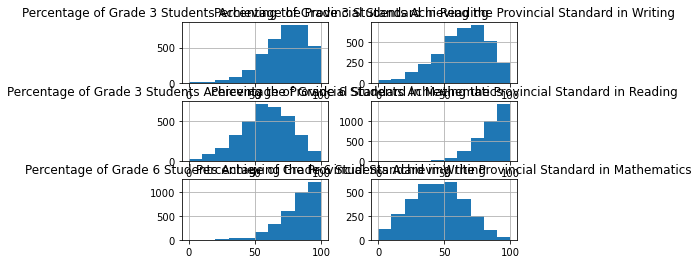

In [45]:
schools[[
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Reading",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Reading",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics",
]].hist()

That all looks quite close to normal distributions, albeit cut off since a percentage needs to be between 0 and 100.

Get the histograms as regular data that we can fit a curve to.

The `np.histogram` produces the bounds rather than the actual x coordinate, so we need to drop the last entry and move everything to the right by half an interval. That way, we get the array of x and y to be the same size which we need for fitting and plotting.

In [46]:
yhist, xhist = np.histogram(schools["Percentage of Grade 6 Students Achieving the Provincial Standard in Reading"].dropna(), bins=20)
xhist=xhist.copy()
xhist.resize(len(xhist)-1)
xhist = xhist + (xhist[1] - xhist[0]) / 2

Now we can fit a normal distribution to this. It has three parameters, the amplitude, the mean (mu) and the standard deviation (sigma). The last argument for `p0` sets some starting conditions.

In [47]:
res = scipy.optimize.curve_fit(lambda x, A, mu, sigma: A*scipy.stats.norm.pdf(x, loc=mu, scale=sigma), xhist, yhist, p0 = [1000, 60, 20])
amplitude, mu, sigma = res[0]
res[0]

array([4.37026715e+04, 1.06125916e+02, 2.08856249e+01])

Let's see how that looks

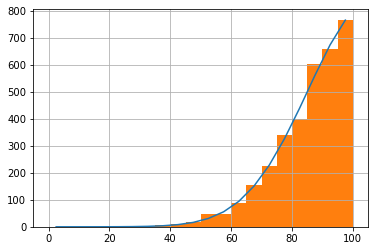

In [49]:
fig, ax = plt.subplots(1, 1)
ax.plot(xhist, amplitude*scipy.stats.norm.pdf(xhist, loc=mu, scale=sigma))
schools["Percentage of Grade 6 Students Achieving the Provincial Standard in Reading"].hist(bins=20)
plt.show()

That's pretty good. Now let's use that distribution to generate random values to fill in for our missing values. We'll use `trucnnorm` which is a truncated version so that we can guarentee that the numbers fall between 0 and 100. The bounds input it takes is in terms of standard deviations though so we need to do some math!

In [50]:
missingdatafiller = pd.DataFrame(scipy.stats.truncnorm((0 - mu) / sigma, (100 - mu) / sigma, loc = res[0][1], scale=res[0][2]).rvs(len(schools)), columns=["Percentage of Grade 6 Students Achieving the Provincial Standard in Reading"])
schools = schools.fillna(missingdatafiller)

In [51]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 19 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   School Type                                                                       4904 non-null   object 
 1   School Level                                                                      4904 non-null   object 
 2   School Language                                                                   4904 non-null   object 
 3   Grade Range                                                                       4904 non-null   object 
 4   Enrolment                                                                         4677 non-null   float64
 5   Percentage of Students Whose First Language Is Not English                        4677 non-null   float64
 6   

Excellent, that column is now completely filled. Let's do the other ones too.

In [52]:
for badcol in [
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Reading",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics",
]:
    yhist, xhist = np.histogram(schools[badcol].dropna(), bins=20)
    xhist=xhist.copy()
    xhist.resize(len(xhist)-1)
    xhist = xhist + (xhist[1] - xhist[0]) / 2

    res = scipy.optimize.curve_fit(lambda x, A, mu, sigma: A*scipy.stats.norm.pdf(x, loc=mu, scale=sigma), xhist, yhist, p0 = [1000, 60, 20])
    amplitude, mu, sigma = res[0]

    missingdatafiller[badcol] = scipy.stats.truncnorm((0 - mu) / sigma, (100 - mu) / sigma, loc = res[0][1], scale=res[0][2]).rvs(len(schools))
schools = schools.fillna(missingdatafiller)

In [53]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 19 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   School Type                                                                       4904 non-null   object 
 1   School Level                                                                      4904 non-null   object 
 2   School Language                                                                   4904 non-null   object 
 3   Grade Range                                                                       4904 non-null   object 
 4   Enrolment                                                                         4677 non-null   float64
 5   Percentage of Students Whose First Language Is Not English                        4677 non-null   float64
 6   

Cool, that is a nice chunk of data. For the other columns, there isn't too much data missing, so lets just drop the missing values for those.

In [54]:
schools = schools.dropna()
schools

,School Type,School Level,School Language,Grade Range,Enrolment,Percentage of Students Whose First Language Is Not English,Percentage of Students Whose First Language Is Not French,Percentage of Students Who Are New to Canada from a Non-English Speaking Country,Percentage of Students Who Are New to Canada from a Non-French Speaking Country,Percentage of Students Receiving Special Education Services,Percentage of Students Identified as Gifted,Percentage of Grade 3 Students Achieving the Provincial Standard in Reading,Percentage of Grade 3 Students Achieving the Provincial Standard in Writing,Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics,Percentage of Grade 6 Students Achieving the Provincial Standard in Reading,Percentage of Grade 6 Students Achieving the Provincial Standard in Writing,Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics,Percentage of School-Aged Children Who Live in Low-Income Households,"Percentage of Students Whose Parents Have No Degree, Diploma or Certificate"
0,Public,Secondary,English,9-12,190.0,0.0,100.0,0.0,0.0,30.0,0.0,58.110932,62.216801,53.892920,89.437777,92.230478,39.345460,20.0,5.0
1,Public,Elementary,English,JK-8,260.0,0.0,100.0,5.0,0.0,15.0,0.0,89.000000,85.000000,85.000000,73.000000,77.000000,50.000000,10.0,0.0
2,Public,Elementary,English,JK-8,185.0,10.0,100.0,10.0,5.0,30.0,0.0,42.000000,21.000000,26.000000,63.000000,58.000000,32.000000,30.0,5.0
3,Public,Elementary,English,JK-8,170.0,0.0,100.0,0.0,0.0,20.0,0.0,68.000000,47.000000,53.000000,75.000000,75.000000,45.000000,20.0,5.0
4,Public,Elementary,English,JK-8,465.0,10.0,95.0,0.0,0.0,5.0,0.0,89.635081,86.820288,23.000000,85.000000,88.000000,59.000000,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4899,Public,Elementary,English,JK-8,645.0,72.0,99.0,14.0,15.0,6.0,0.0,77.000000,77.000000,76.000000,89.000000,94.000000,74.000000,17.0,4.0
4900,Public,Secondary,English,9-12,495.0,50.0,100.0,10.0,10.0,20.0,0.0,68.718331,85.056781,48.935229,74.298966,62.029221,43.544221,10.0,10.0
4901,Public,Elementary,English,JK-8,515.0,52.0,100.0,8.0,8.0,7.0,0.0,61.000000,65.000000,50.000000,74.000000,70.000000,35.000000,14.0,7.0
4902,Public,Elementary,English,1-8,245.0,50.0,100.0,0.0,0.0,0.0,0.0,79.512337,78.191848,49.967951,93.000000,96.000000,80.000000,20.0,0.0


We still have a few columns that are text values. We can do the same thing as before with the dummies.

In [55]:
dummies = schools["School Type"].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('schooltype_')
schools = schools.join(dummies)
dummies = schools["School Level"].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('schoollevel_')
schools = schools.join(dummies)
dummies = schools["School Language"].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('schoollanguage_')
schools = schools.join(dummies)
dummies = schools["Grade Range"].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('graderange_')
schools = schools.join(dummies)

We don't need the columns that we created the dummies from anymore, so lets drop those.

In [56]:
schools = schools.drop(["School Type", "School Level", "School Language", "Grade Range"], axis=1)

Now our data is in good shape. Well, we hope anyway!

In [57]:
np.histogram(schools["Percentage of Students Whose Parents Have No Degree, Diploma or Certificate"], bins=5)

(array([4136,  448,   69,   17,    7]), array([ 0., 12., 24., 36., 48., 60.]))

In [58]:
X = schools.drop("Percentage of Students Whose Parents Have No Degree, Diploma or Certificate", axis=1)
y = schools["Percentage of Students Whose Parents Have No Degree, Diploma or Certificate"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.03418803418803419


In [59]:
X = schools.drop("Percentage of Students Whose Parents Have No Degree, Diploma or Certificate", axis=1)
y = np.floor(schools["Percentage of Students Whose Parents Have No Degree, Diploma or Certificate"] / 20)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.2232905982905983


<AxesSubplot:xlabel='Percentage of Students Whose Parents Have No Degree, Diploma or Certificate', ylabel='Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics'>

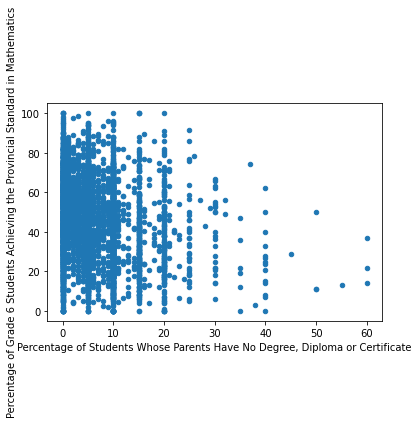

In [60]:
schools.plot(y = "Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics", x = "Percentage of Students Whose Parents Have No Degree, Diploma or Certificate", kind="scatter")

<AxesSubplot:>

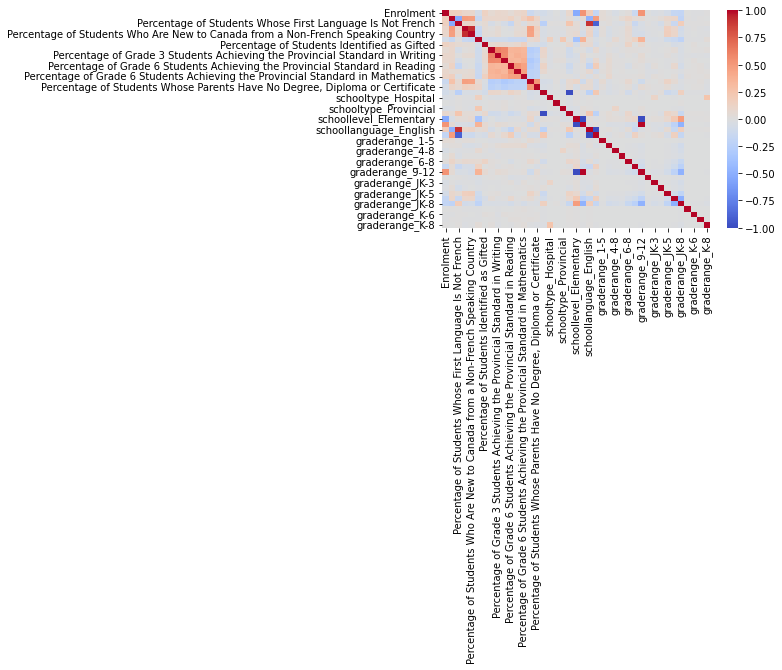

In [67]:
sns.heatmap(schools.corr(), cmap="coolwarm")

In [68]:
schools.columns

Index(['Enrolment',
       'Percentage of Students Whose First Language Is Not English',
       'Percentage of Students Whose First Language Is Not French',
       'Percentage of Students Who Are New to Canada from a Non-English Speaking Country',
       'Percentage of Students Who Are New to Canada from a Non-French Speaking Country',
       'Percentage of Students Receiving Special Education Services',
       'Percentage of Students Identified as Gifted',
       'Percentage of Grade 3 Students Achieving the Provincial Standard in Reading',
       'Percentage of Grade 3 Students Achieving the Provincial Standard in Writing',
       'Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics',
       'Percentage of Grade 6 Students Achieving the Provincial Standard in Reading',
       'Percentage of Grade 6 Students Achieving the Provincial Standard in Writing',
       'Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics',
       'Percen

<AxesSubplot:>

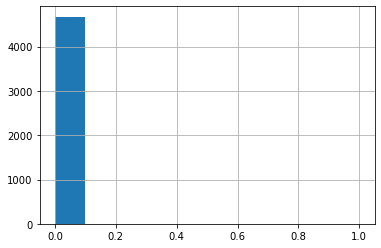

In [70]:
schools["graderange_1-5"].hist()

## Tips

Tips to improve the model

    Try transforming the variables using transformations like BoxCox or YeoJohnson to make the features near Normal.
    Try applying Laplace correction to handle records with zeros values in X variables.
    Check for correlated features and try removing the highly correlated ones. Naive Bayes is based on the assumption that the features are independent.
    Feature engineering. Combining features (a product) to form new ones that makes intuitive sense might help.
    Try providing more realistic prior probabilities to the algorithm based on knowledge from business, instead of letting the algo calculate the priors based on the training sample.

Strength

    Even though the naive assumption is rarely true, the algorithm performs surprisingly good in many cases
    Handles high dimensional data well. Easy to parallelize and handles big data well
    Performs better than more complicated models when the data set is small

Weakness

    The estimated probability is often inaccurate because of the naive assumption. Not ideal for regression use or probability estimation
    When data is abundant, other more complicated models tend to outperform Naive Bayes